In [6]:
# !pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="FCU93BcxuehxfGxgw9Gq")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-4 in yolov8:: 100%|██████████| 48488/48488 [09:55<00:00, 81.49it/s]


In [9]:
import os

from ultralytics import YOLO


# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch

# Use the model
# results = model.train(data=os.path.join(ROOT_DIR, "config.yaml"), epochs=1)  # train the model
results = model.train(data="config.yaml", epochs=1)  # train the model


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
import os
import re
import torch

In [2]:
# load models

model_dir = 'models/best.pt'

plates_detect_model = YOLO(model_dir)

In [16]:
def video2imageFolder(input_file, output_path):
    '''
    Extracts the frames from an input video file
    and saves them as separate frames in an output directory.
    Input:
        input_file: Input video file.
        output_path: Output directorys.
    Output:
        None
    '''

    cap = cv2.VideoCapture()
    cap.open(input_file)

    if not cap.isOpened():
        print("Failed to open input video")

    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    frame_idx = 0
    frame_count -= 2
    print(frame_count)
    while frame_idx < frame_count:
        ret, frame = cap.read()

        if not ret:
            print ("Failed to get the frame {}".format(frame_idx))
            continue

        out_name = os.path.join(output_path, 'f{:04d}.jpg'.format(frame_idx+1))
        ret = cv2.imwrite(out_name, frame)
        if not ret:
            print ("Failed to write the frame {}".format(frame_idx))
            continue

        frame_idx += 1
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

In [17]:
# transfer video to images
video2imageFolder('sample1.mp4', 'images/')

416.0


In [27]:
frame1 = cv2.imread('images/f0109.jpg')

In [28]:
imageHeight, imageWidth, _ = frame1.shape

In [29]:
# load frames
frameCount = 416

root_directory = 'images/'

frames = {}

idx = 0

for root, dirs, files in os.walk(root_directory):
        print(len(files))
        for file in sorted(files):
            frames[idx] = cv2.imread(os.path.join(root, file))
            idx += 1
            
if idx != frameCount:
    raise ValueError("Frame count mismatch. Expected {}, but loaded {} frames.".format(frameCount, idx))

416


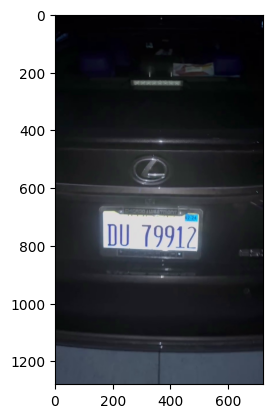

In [36]:
plt.imshow(frame1)

In [30]:
# first step, process image to recognize the license plate
# detect license plates from a picture

license_plates_frame1 = plates_detect_model(frame1)[0]



0: 640x384 1 plate, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


In [31]:
def read_license_plate(license_plate_crop):
    reader = easyocr.Reader(['en'], gpu=False)
    ans = ''
        
    # Perform OCR
    result = reader.readtext(license_plate_crop)

    # Print results
    for detection in result:
        text = detection[1]
#         print(f'text is {text}')
        filtered_text = re.sub(r'[^A-Za-z0-9 ]', '', text).upper()
#         print(f'filtered_text is {filtered_text}')
        ans += filtered_text
        

    return ans

In [32]:
def get_license_plate_from_image(license_plates, sample):

    result = np.copy(sample)
    license_plate_crop_rgb = None
    for license_plate in license_plates.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = license_plate

        # crop plate
        license_plate_crop = sample[int(y1): int(y2), int(x1): int(x2), :]

        # process license plate
        license_plate_crop_rgb = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2RGB)
        
        
        # process license plate
        gray = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2GRAY)
#         blur = cv2.GaussianBlur(gray, (5,5), 0) 
        
        
        
#         edges = cv2.Canny(blur, 10, 30) 
        
        
        
#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         plt.imshow(blur)
#         plt.title('Original Plate')
#         plt.show()
        
        
        
        # read license plate number
        license_plate_text = read_license_plate(gray)
        
#         print(f'license_plate_text is {license_plate_text}')
        # draw the line to original picture 
        cv2.rectangle(result, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Green rectangle
        cv2.putText(result, license_plate_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
    
    return license_plate_crop_rgb, result

Using CPU. Note: This module is much faster with a GPU.


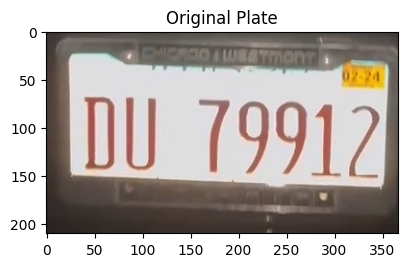

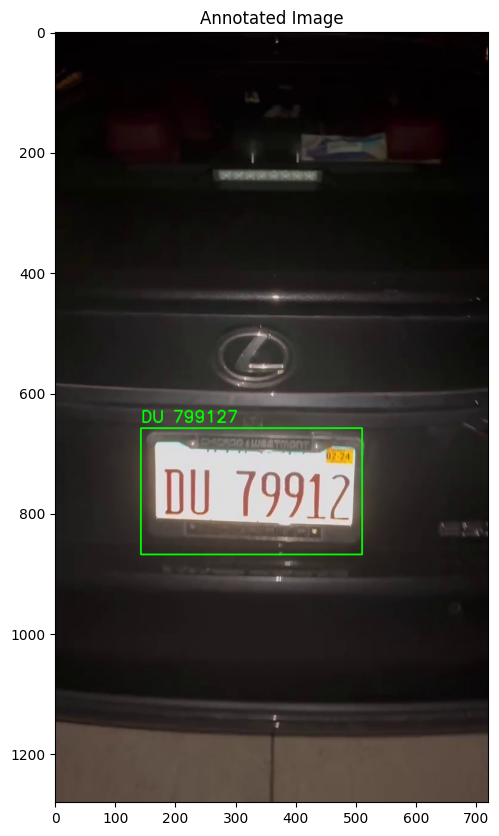

In [33]:
# show process of frame1

license_plate_crop_rgb, result = get_license_plate_from_image(license_plates_frame1, frame1)

# plot crop plate
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(license_plate_crop_rgb)
plt.title('Original Plate')
plt.show()


# plot result image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)) 
plt.title('Annotated Image')
plt.show()

In [34]:
# process all frames

for i in range(frameCount):
    
    plate = plates_detect_model(frames[i])[0]
    
    plate_crop_rgb, result = get_license_plate_from_image(plate, frames[i])

    # save result to folder
    cv2.imwrite('processed_images/a{:04d}.jpg'.format(i+1), result)
    


0: 640x384 (no detections), 77.3ms
Speed: 2.0ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 57.0ms
Speed: 2.0ms preprocess, 57.0ms i

Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 53.0ms
Speed: 1.0ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 4 plates, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 72.0ms
Speed: 2.0ms preprocess, 72.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 76.0ms
Speed: 1.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 4 plates, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 4 plates, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 56.0ms
Speed: 1.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 52.0ms
Speed: 2.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 61.5ms
Speed: 2.0ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 63.0ms
Speed: 1.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 3 plates, 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 61.0ms
Speed: 14.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 1.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 80.0ms
Speed: 2.0ms preprocess, 80.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 1.0ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 71.0ms
Speed: 4.0ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 1.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 72.0ms
Speed: 2.0ms preprocess, 72.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 1.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 1.0ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 72.0ms
Speed: 2.0ms preprocess, 72.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 77.0ms
Speed: 2.0ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 88.5ms
Speed: 2.0ms preprocess, 88.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 60.5ms
Speed: 2.0ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 76.0ms
Speed: 2.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 73.5ms
Speed: 2.0ms preprocess, 73.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 3.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 55.0ms
Speed: 1.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 87.0ms
Speed: 4.0ms preprocess, 87.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 61.0ms
Speed: 1.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 79.0ms
Speed: 2.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 70.0ms
Speed: 3.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 72.0ms
Speed: 1.0ms preprocess, 72.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 54.0ms
Speed: 2.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 72.0ms
Speed: 2.0ms preprocess, 72.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 70.0ms
Speed: 1.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 1.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 77.0ms
Speed: 2.0ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 72.0ms
Speed: 2.0ms preprocess, 72.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 3.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 1.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 76.0ms
Speed: 2.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 2 plates, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 71.0ms
Speed: 2.0ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 1.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 70.0ms
Speed: 3.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 3.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 1.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 1.0ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 1.0ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.5ms
Speed: 2.0ms preprocess, 63.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 70.0ms
Speed: 2.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 70.0ms
Speed: 2.0ms preprocess, 70.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 75.0ms
Speed: 3.0ms preprocess, 75.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 97.1ms
Speed: 3.0ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 1.7ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 82.0ms
Speed: 2.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 1.0ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 84.0ms
Speed: 4.0ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 1.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 75.0ms
Speed: 2.0ms preprocess, 75.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 1.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 75.0ms
Speed: 2.0ms preprocess, 75.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.



0: 640x384 1 plate, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Using CPU. Note: This module is much faster with a GPU.


In [37]:
def imageFolder2mpeg(input_path, output_path='./output_video.mpeg', fps=30.0):
    '''
    Extracts the frames from an input video file
    and saves them as separate frames in an output directory.
    Input:
        input_path: Input video file.
        output_path: Output directorys.
        fps: frames per second (default: 30).
    Output:
        None
    '''

    dir_frames = input_path
    files_info = os.scandir(dir_frames)

    file_names = [f.path for f in files_info if f.name.endswith(".jpg")]
    file_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    frame_Height, frame_Width = cv2.imread(file_names[0]).shape[:2]
    resolution = (frame_Width, frame_Height)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MPG1')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, resolution)

    frame_count = len(file_names)

    frame_idx = 0

    while frame_idx < frame_count:


        frame_i = cv2.imread(file_names[frame_idx])
        video_writer.write(frame_i)
        frame_idx += 1

    video_writer.release()

In [38]:
imageFolder2mpeg('processed_images')